HG: high-grade gliomas
LG: low grade gilomas

In [1]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optimizer
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from tqdm.auto import tqdm
from glob import glob
from os import path
from torchvision.utils import save_image
import torch.nn as nn
from torch.nn import init
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import cv2
from IPython.display import clear_output
from matplotlib.colors import LinearSegmentedColormap
from torchvision.transforms.functional import pad
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

## Dataset 확인

In [2]:
#####
# dataset shape -> [modality, h, d, w]
# dataset  -> data[0] : MR_Flair
# dataset  -> data[1] : MR_T1
# dataset  -> data[2] : MR_T1c
# dataset  -> data[3] : MR_T2
# [1] label necrosis
# [2] label edema
# [3] label non-enhancing tumor
# [4] label enhancing tumor
# [0] label everything else
#####

path = './BRATS-2/Image_Data/HG/0006/'
p = os.listdir(path)
p.sort(key=str.lower)
data = []
for i in range(len(p)):
    if(i != 4):
        p1 = os.listdir(path+'/'+p[i])
        print(p1)
        p1.sort()
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
        data.append( sitk.GetArrayFromImage(img))
    else:
        p1 = os.listdir(path+'/'+p[i])
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
        Y_labels = sitk.GetArrayFromImage(img) 


['License_CC_BY_NC_SA_3.0.txt', 'VSD.Brain.XX.O.MR_Flair.715.mha']
['License_CC_BY_NC_SA_3.0.txt', 'VSD.Brain.XX.O.MR_T1.716.mha']
['License_CC_BY_NC_SA_3.0.txt', 'VSD.Brain.XX.O.MR_T1c.717.mha']
['License_CC_BY_NC_SA_3.0.txt', 'VSD.Brain.XX.O.MR_T2.718.mha']


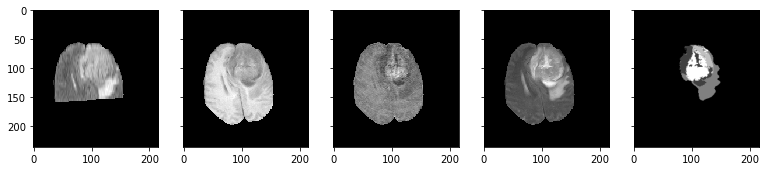

In [105]:
f,axes = plt.subplots(1,5,sharex =True,sharey=True)
f.set_size_inches((13,3))
for i in range(4):
    axes[i].imshow(data[i][128],cmap='gray',interpolation ="none")
axes[4].imshow(Y_labels[128],cmap='gray')

In [42]:
data[0].dtype,data[0].shape,Y_labels.shape

(dtype('int16'), (176, 236, 216))

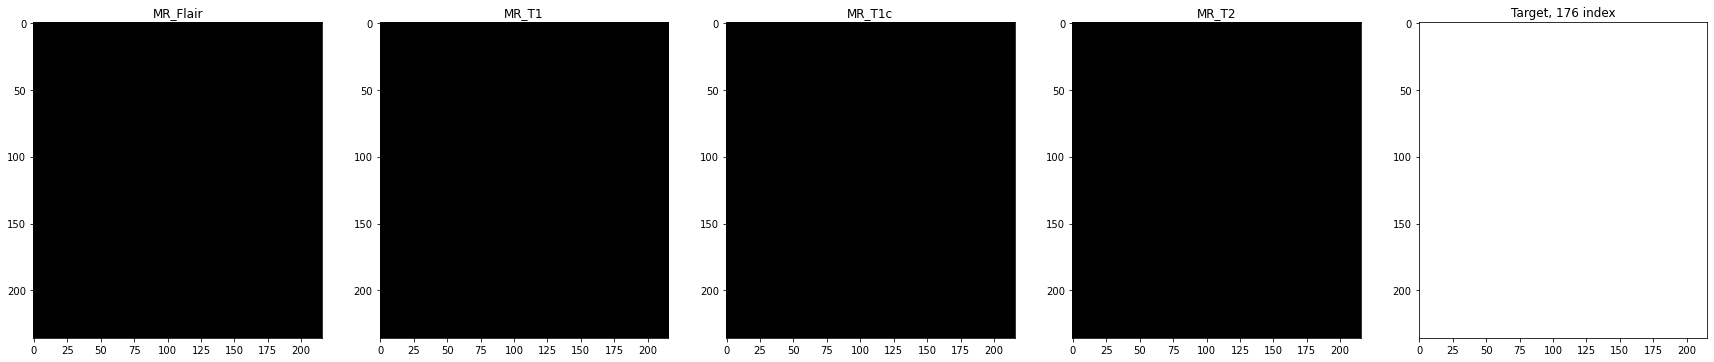

In [55]:
def imshow1(img):
    plt.imshow(img, cmap='gray',  interpolation='none') # interpolation: 보간법, 
def imshow2(mask):
    plt.imshow(mask, cmap=map_object, alpha=0.7,  interpolation='none')


# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

i = 0
for pic1, pic2, pic3, pic4, tar in zip(data[0], data[1], data[2], data[3], Y_labels):
    i+=1
    plt.figure(figsize=(30,30))
    plt.subplot(1,5,1)
    plt.title('MR_Flair')
    imshow1(pic1)
    plt.subplot(1,5,2)
    plt.title('MR_T1')
    imshow1(pic2)
    plt.subplot(1,5,3)
    plt.title('MR_T1c')
    imshow1(pic3)
    plt.subplot(1,5,4)
    plt.title('MR_T2')
    imshow1(pic4)
    plt.subplot(1,5,5)
    plt.title('Target, {} index'.format(i))
    imshow2(tar)
    plt.show()
    clear_output(wait=True)

<img src="multi-label-data.png" width="500px" height="500px">  <img src="multi-label-one-hot.png" width="636" height="636">

                           Multi-Label Data                                                          One-Hot Encoding
                          

## Multi-Label data의 One-Hot Encoding 방법

In [20]:
np.unique(Y_labels)#중복 제거, #총 레이블이 5개

array([0, 1, 2, 3, 4], dtype=int16)

In [30]:
tensor_Y_labels = torch.tensor(Y_labels, dtype=torch.int64) 
torch.unique(tensor_Y_labels), tensor_Y_labels.shape

(tensor([0, 1, 2, 3, 4]), torch.Size([176, 236, 216]))

In [35]:
torch.nn.functional.one_hot(tensor_Y_labels).shape

torch.Size([176, 236, 216, 5])

In [60]:
torch.nn.functional.one_hot(tensor_Y_labels)[128,:,:,0]

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

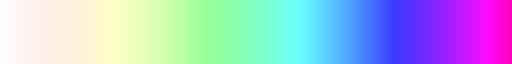

In [160]:
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
# color_array = plt.get_cmap('gist_rainbow')(range(ncolors))


# color_array = plt.get_cmap('plasma')(range(ncolors))
# color_array[:,-1] = np.linspace(0.0,1.0,ncolors)


# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)
map_object

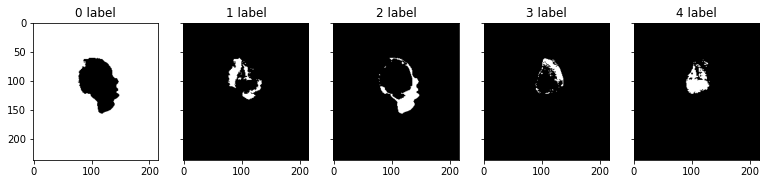

In [157]:
title =[f'{i} label'for i in range(5)]
f,axes = plt.subplots(1,5,sharex =True,sharey=True)
f.set_size_inches((13,3))
for i in range(5):
    axes[i].set_title(f'{title[i]}')
    axes[i].imshow(torch.nn.functional.one_hot(tensor_Y_labels)[128,:,:,i],cmap ='gray')
    # plt.imshow(mask, cmap=map_object, alpha=0.7,  interpolation='none')
    

In [8]:
torch.nn.functional.one_hot(tensor_Y_labels).shape

torch.Size([176, 236, 216, 5])

In [139]:
torch.nn.functional.one_hot(tensor_Y_labels).permute(3, 0, 1, 2).shape#transpose는 2개의 차원만 바꾸지만, permute는 2개 이상 가능  

torch.Size([5, 176, 236, 216])

In [141]:
label = torch.nn.functional.one_hot(tensor_Y_labels).permute(3, 0, 1, 2)

In [11]:
label.shape

torch.Size([5, 176, 236, 216])

### One-hot 확인

In [149]:
title

['original',
 'one-hot without 0 label',
 '0 label',
 '1 label',
 '2 label',
 '3 label',
 '4 label']

In [ ]:
title= ['original','one-hot without 0 label']+[f'{i} label'for i in range(5)]
d = [Y_labels[100],l]
f, axes = plt.subplots(1,7,sharex=True,sharey=True)
f.set_size_inches((13,3))
data
for i in range(7):
    axes[]
    axes[i].set_title("{}".format(title[i]))

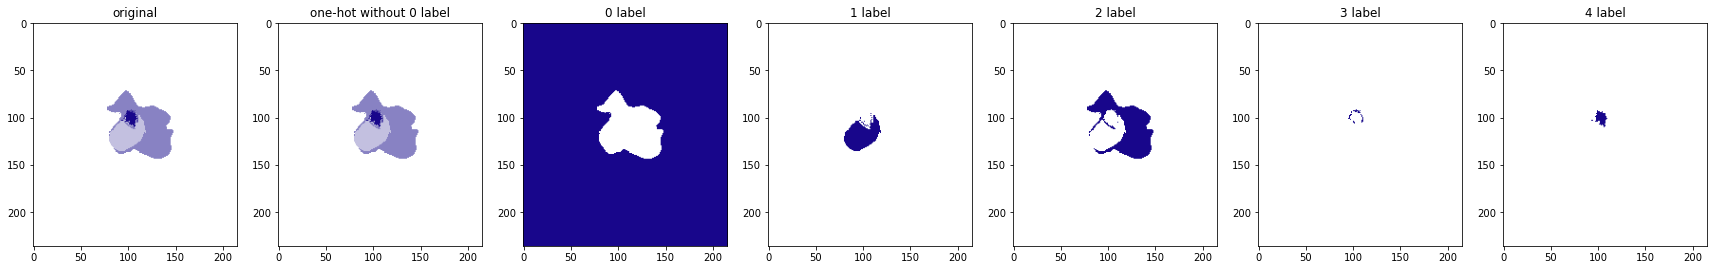

In [142]:
plt.figure(figsize=(30,30))
plt.subplot(1,7,1)
plt.title('original')
plt.imshow(Y_labels[100], cmap=map_object)
plt.subplot(1,7,2)
plt.title('one-hot without 0 label')
plt.imshow(label[1][100]+label[2][100]*2+label[3][100]*3+label[4][100]*4, cmap=map_object)
plt.subplot(1,7,3)
plt.title('0 label')
plt.imshow(label[0][100], cmap=map_object)
plt.subplot(1,7,4)
plt.title('1 label')
plt.imshow(label[1][100], cmap=map_object)
plt.subplot(1,7,5)
plt.title('2 label')
plt.imshow(label[2][100], cmap=map_object)
plt.subplot(1,7,6)
plt.title('3 label')
plt.imshow(label[3][100], cmap=map_object)
plt.subplot(1,7,7)
plt.title('4 label')
plt.imshow(label[4][100], cmap=map_object)
plt.show()

In [14]:
label = torch.nn.functional.one_hot(tensor_Y_labels).permute(3, 0, 1, 2)[1:]

In [15]:
label.shape #normal은 없는 상태 

torch.Size([4, 176, 236, 216])

## zero padding, one-hot encoding

-----
data shape -> [slice, modality, x, y]

modality

[0] : MR_Flair

[1] : MR_T1

[2] : MR_T1c

[3] : MR_T2

In [105]:
#####
# dataset shape -> [modality, h, d, w]
# dataset  -> data[0] : MR_Flair
# dataset  -> data[1] : MR_T1
# dataset  -> data[2] : MR_T1c
# dataset  -> data[3] : MR_T2

# [1] label necrosis
# [2] label edema
# [3] label non-enhancing tumor
# [4] label enhancing tumor
# [0] label everything else
#####

root = './BRATS-2/Image_Data/HG/'
dirc = os.listdir(root)
print(dirc)
data = []
label = []
for d in dirc:
    path = root+d
    p = os.listdir(path)
    p.sort(key=str.lower)
    modality = []
    for i in range(len(p)):
        if(i != 4):
            p1 = os.listdir(path+'/'+p[i])
            p1.sort()
            img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
            modality.append(sitk.GetArrayFromImage(img))
        else:
            p1 = os.listdir(path+'/'+p[i])
            img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
            Y_labels = sitk.GetArrayFromImage(img) 
            tensor_Y_labels = torch.tensor(Y_labels, dtype=torch.int64) 
            patient_label = torch.nn.functional.one_hot(tensor_Y_labels).permute(0, 3, 1, 2)[:,1:,...]
            label.append(patient_label)
            
    data.append(torch.tensor(modality).permute(1, 0, 2, 3))

['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0022', '0024', '0025', '0026', '0027']


In [106]:
data[0].shape, label[0].shape

(torch.Size([176, 4, 216, 160]), torch.Size([176, 4, 216, 160]))

In [107]:
cnt = 0
for i in range(20):
    print(data[i].shape, label[i].shape)
    cnt += data[i].shape[0]
print('total pic num : ', cnt)

torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([176, 4, 216, 176]) torch.Size([176, 4, 216, 176])
torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([176, 4, 236, 216]) torch.Size([176, 4, 236, 216])
torch.Size([176, 4, 216, 176]) torch.Size([176, 4, 216, 176])
torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([176, 4, 216, 176]) torch.Size([176, 4, 216, 176])
torch.Size([176, 4, 216, 176]) torch.Size([176, 4, 216, 176])
torch.Size([176, 4, 216, 176]) torch.Size([176, 4, 216, 176])
torch.Size([176, 4, 216, 176]) torch.Size([176, 4, 216, 176])
torch.Size([176, 4, 216, 160]) torch.Size([176, 4, 216, 160])
torch.Size([165, 4, 230, 230]) torch.Size([165, 4, 230, 230])
torch.Si

In [108]:
def get_padding(image):
    max_w = 240 
    max_h = 240
    
    imsize = image[0].shape
    h_padding = (max_w - imsize[0]) / 2
    v_padding = (max_h - imsize[1]) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    
    padding = (int(t_pad), int(l_pad), int(b_pad), int(r_pad))
    
    return padding

def pad_image(image):
        padded_im = pad(image, get_padding(image))
        return padded_im

In [132]:
mode = ['MR_Flair', 'MR_T1', 'MR_T1c', 'MR_T2']
i = 0
for patient_num in tqdm(range(20)):
    for slice_num in range(data[patient_num].shape[0]):
        pad_data = pad_image(data[patient_num][slice_num])
        pad_label = pad_image(label[patient_num][slice_num])
        for modality in range(4):
            plt.imsave("./BRATS_Padding/image/{}/{}.png".format(mode[modality], i), pad_data[modality],  cmap='gray')
        for label_i in range(4):
            plt.imsave("./BRATS_Padding/label/{}/{}.png".format(label_i, i), pad_label[label_i],  cmap='gray')
        i+=1

  0%|          | 0/20 [00:00<?, ?it/s]

In [85]:
data[0].shape

torch.Size([176, 4, 216, 160])

In [8]:
class Classification_Dataset(Dataset):
    '''
    input : index list 0 ~ 3724
    '''
    def __init__(self, index_list):
        self.index_list = index_list

    def __len__(self):        
        return len(self.index_list)


    def __getitem__(self, index):   
        MR_Flair = Image.open("./BRATS_Padding/image/MR_Flair/{}.png".format(self.index_list[index])).convert('L')
        MR_T1 = Image.open("./BRATS_Padding/image/MR_T1/{}.png".format(self.index_list[index])).convert('L')
        MR_T1c = Image.open("./BRATS_Padding/image/MR_T1c/{}.png".format(self.index_list[index])).convert('L')
        MR_T2 = Image.open("./BRATS_Padding/image/MR_T2/{}.png".format(self.index_list[index])).convert('L')
        
        target0 = Image.open("./BRATS_Padding/label/0/{}.png".format(self.index_list[index])).convert('L')
        target1 = Image.open("./BRATS_Padding/label/1/{}.png".format(self.index_list[index])).convert('L')
        target2 = Image.open("./BRATS_Padding/label/2/{}.png".format(self.index_list[index])).convert('L')
        target3 = Image.open("./BRATS_Padding/label/3/{}.png".format(self.index_list[index])).convert('L')
        
        trans = transforms.Compose([transforms.ToTensor()])
        MR_Flair, MR_T1, MR_T1c, MR_T2 = trans(MR_Flair), trans(MR_T1), trans(MR_T1c), trans(MR_T2)
        target0, target1, target2, target3 = trans(target0), trans(target1), trans(target2), trans(target3)
        image = torch.stack((MR_Flair, MR_T1, MR_T1c, MR_T2)).squeeze(1)
        target = torch.stack((target0, target1, target2, target3)).squeeze(1)
        return image, target

In [9]:
indx = np.arange(3725)

In [10]:
dataset = Classification_Dataset(indx)

In [6]:
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

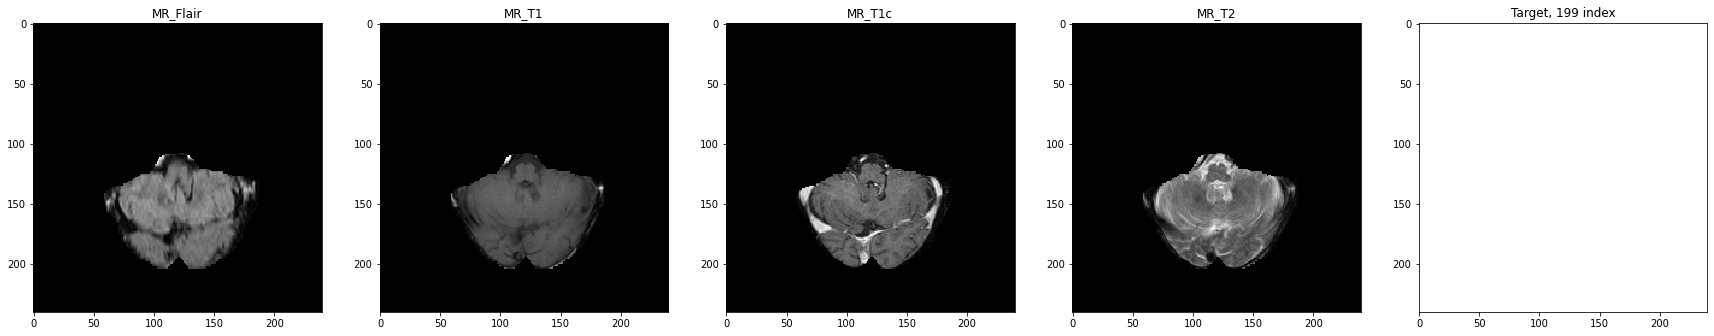

In [152]:
i=0
for img, label in dataset_loader:
    plt.figure(figsize=(30,30))
    plt.subplot(1,5,1)
    plt.title('MR_Flair')
    imshow1(img[0][0])
    plt.subplot(1,5,2)
    plt.title('MR_T1')
    imshow1(img[0][1])
    plt.subplot(1,5,3)
    plt.title('MR_T1c')
    imshow1(img[0][2])
    plt.subplot(1,5,4)
    plt.title('MR_T2')
    imshow1(img[0][3])
    plt.subplot(1,5,5)
    plt.title('Target, {} index'.format(i))
    imshow2((label[0][0]+label[0][1]*2+label[0][2]*3+label[0][3]*4)[0])
    plt.show()
    i+=1
    if i == 200:
        break
    clear_output(wait=True)

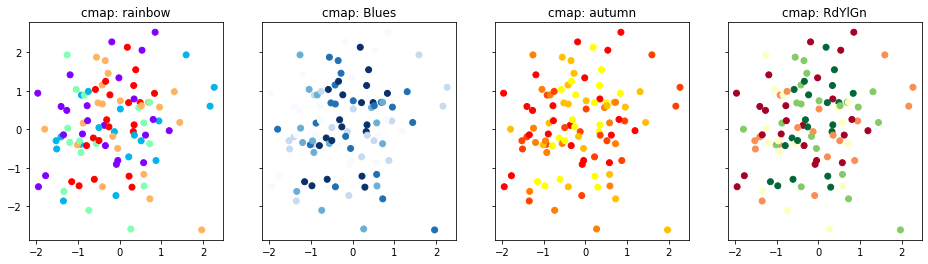

In [41]:
X = np.random.normal(0, 1, 100)
Y = np.random.normal(0, 1, 100)
C = np.random.randint(0, 5, 100)
cmap_lst = [plt.cm.rainbow, plt.cm.Blues, plt.cm.autumn, plt.cm.RdYlGn]

f, axes = plt.subplots(1, 4, sharex=True, sharey=True) # x,y축을 공유할 것인가에 대한 parameter
f.set_size_inches((16, 4))  #figsize를 조절 
for i in range(0, 4):
    axes[i].scatter(X, Y, c=C, cmap=cmap_lst[i]) #c: array-like or list of colors or color
    axes[i].set_title("cmap: {}".format(cmap_lst[i].name))
# plt.savefig('../../assets/images/markdown_img/180601_plt_cmap_variation.svg')
plt.show()

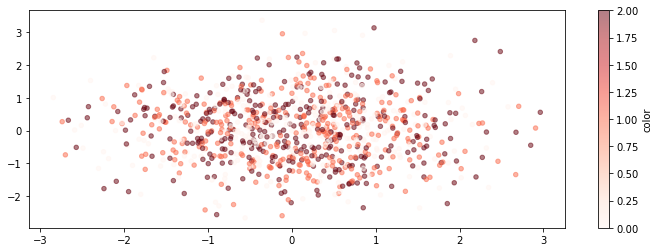

In [18]:
sample_size = 1000
color_num = 3

X = np.random.normal(0, 1, sample_size)
Y = np.random.normal(0, 1, sample_size)
C = np.random.randint(0, color_num, sample_size)

plt.figure(figsize=(12, 4))
plt.scatter(X, Y, c=C, s=20, cmap=plt.cm.Reds, alpha=0.5)
plt.colorbar(label='color')
# plt.savefig('../../assets/images/markdown_img/180601_colorbar_numeric_data.svg')
plt.show()

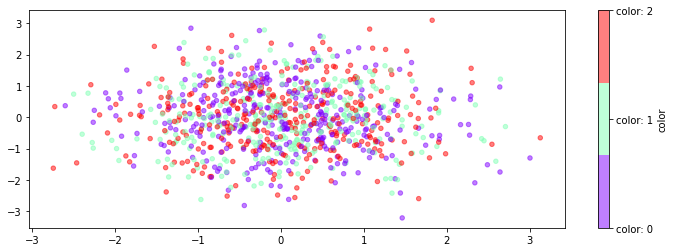

In [19]:
sample_size = 1000
color_num = 3

X = np.random.normal(0, 1, sample_size)
Y = np.random.normal(0, 1, sample_size)
C = np.random.randint(0, color_num, sample_size)

plt.figure(figsize=(12, 4))
plt.scatter(X, Y, c=C, s=20, cmap=plt.cm.get_cmap('rainbow', color_num), alpha=0.5)
plt.colorbar(ticks=range(color_num), format='color: %d', label='color')
# plt.savefig('../../assets/images/markdown_img/180601_colorbar_categorical_data.svg')
plt.show()